In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

2023-12-18 09:48:04.845635: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-18 09:48:04.977045: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-18 09:48:05.862958: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.8/lib64:/usr/local/cuda-11.3/lib64
2023-12-18 09:48:05.863073: W te

In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
with tf.compat.v1.Session(config=config) as sess:

    # 메모리 40% 할당
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.9
    sess = tf.compat.v1.Session(config=config)

2023-12-17 18:44:55.022371: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-17 18:44:56.289117: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 360 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0
2023-12-17 18:44:56.313548: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 360 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


In [3]:
import pickle

with open('./Pretraning_data/ZINC_10M_data','rb') as file:
    train = pickle.load(file)

In [4]:
train[1]

'O=C(NC(=O)c1cccc(F)c1)O[C@H]1CCS(=O)(=O)C1'

In [5]:
from Module import RDK
RDK.smile_tokenize(train[1:5])

[['O=C(N', 'C(=O)', 'c1cccc(F)', 'c1)O', '[C@H]1CC', 'S(=O)(=O)C1'],
 ['C',
  'n1ccnc1C',
  '[N@@H+]1C',
  '[C@@H](O)',
  '[C@H](O',
  'c2cccc(',
  'C(=O)[O-])',
  'c2)C1'],
 ['C',
  'n1ccnc1C',
  '[N@H+]1C',
  '[C@@H](O)',
  '[C@H](O',
  'c2cccc(',
  'C(=O)[O-])',
  'c2)C1'],
 ['CS(=O)(=O)', 'c1cn[nH]c1', '[C@H]1CC', 'N(C(=O)', 'c2cnccn2)', 'C1']]

In [6]:
from Module import RDK
RDK.smile_tokenize(train[1:5])


[['O=C(', 'NC(=O)', 'c1cccc(F)c1)', 'O[C@H]1', 'CCS(=O)(=O)', 'C1'],
 ['Cn1cc',
  'nc1C',
  '[N@@H+]',
  '1',
  'C[C@@H](O)',
  '[C@H](O',
  'c2cccc(',
  'C(=O)',
  '[O-])',
  'c2)C1'],
 ['Cn1cc',
  'nc1C',
  '[N@H+]',
  '1',
  'C[C@@H](O)',
  '[C@H](O',
  'c2cccc(',
  'C(=O)',
  '[O-])',
  'c2)C1'],
 ['CS(=O)(=O)',
  'c1cn',
  '[nH]c1',
  '[C@H]1',
  'CCN(C(=O)',
  'c2cn',
  'cc',
  'n2)C1']]

In [6]:
from rdkit import Chem
from tqdm import tqdm
def Chem_generator(smiles):
    res_list = []
    for i in tqdm(smiles):
        mol = Chem.MolFromSmiles(i)
        temp = []
        index = 0
        while(len(set(temp))!=4 and index != 100):
            index+=1
            temp.append(Chem.MolToSmiles(mol,doRandom=True))
        res_list+=list(set(temp))
    return res_list

In [7]:
train_1 = Chem_generator(train)

  0%|          | 1849/12525050 [00:01<1:56:13, 1795.88it/s]

100%|██████████| 12525050/12525050 [1:25:08<00:00, 2451.74it/s]


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf
def scaled_dot_product(Q,K,V):
        mat_QK = tf.matmul(Q,K,transpose_b=True)
        depth = tf.cast(tf.shape(K)[-1], tf.float32)
        logits = mat_QK / tf.math.sqrt(depth)
    

        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, V)

        return output, attention_weights

class self_multihead(tf.keras.layers.Layer):
    def __init__(self,d_model,num_heads,name='multiheadatten'):
        super(self_multihead,self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model%num_heads == 0

        self.depth = d_model//self.num_heads
        self.Q = Dense(units=d_model)
        self.K = Dense(units=d_model)
        self.V = Dense(units=d_model)

        self.linear = Dense(units = d_model)

    def split(self,inputs,batch_size):
        inputs = tf.reshape(inputs, [batch_size,-1,self.num_heads,self.depth])
        return tf.transpose(inputs,perm=[0,2,1,3])

    def call(self,inputs):
        Q,K,V = inputs,inputs,inputs
        batch_size = tf.shape(Q)[0]
        
        # Denselayer
        Q = self.Q(Q)
        K = self.K(K)
        V = self.V(V)
        #Splithead 

        Q = self.split(Q,batch_size)
        K = self.split(K,batch_size)
        V = self.split(V,batch_size)
        #Scaled dot product
        scaled_att,_ = scaled_dot_product(Q,K,V)
        #(batchsize,sentence_size,num_heads,word_size/num_heads)
        scaled_attention = tf.transpose(scaled_att, perm=[0,2,1,3])
        #Concate
        concat_attention = tf.reshape(scaled_attention, [batch_size, -1, self.d_model])
        #Linear Dense
        outputs = self.linear(concat_attention)

        return outputs



def scheduler(epochs,lr):
    lr = 0.5*(1+np.cos(np.pi * epochs / 100))
    if epochs <= 5:
        lr *= epochs * 1.0 / 30
    return lr

class transformer(tf.keras.layers.Layer):
    def __init__(self,d_model,num_heads,ff_dim,name):
        super(transformer,self).__init__(name=name)
        self.attn = self_multihead(d_model,num_heads)
        self.ff = Sequential([Dense(ff_dim,activation='relu'),Dense(d_model)])
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
    
    def call(self, inputs):
        attn_out = self.attn(inputs)
        out1 = self.norm1(inputs + attn_out)
        ffn_output = self.ff(out1)
        return self.norm2(out1 + ffn_output)

class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,mask_zero=True)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim,mask_zero = True)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=1, limit=maxlen+1, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        mask = self.token_emb.compute_mask(x)
        return x + positions
    

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        l2_reg = tf.keras.regularizers.l2(0.01)
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim,kernel_regularizer=l2_reg,dropout=0.1)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [9]:
def replace_zeros_with_ones(input_tensor):
    # input_tensor에서 0인 값을 1로 바꾸는 연산
    modified_tensor = tf.where(tf.equal(input_tensor, 0), 1, input_tensor)
    return modified_tensor


def calculate_means(input_list, index_ranges):
    # TensorFlow 상수로 입력 리스트를 변환
    input_tensor = tf.constant(input_list)
    
    # 각각의 인덱스 범위를 나누어 평균 계산
    averages = [tf.reduce_mean(input_tensor[start:end]) for start, end in index_ranges]
    
    return averages


class Mask(tf.keras.layers.Layer):
    def __init__(self):
        super(Mask, self).__init__()
    def call(self, inputs,mask):
        prob = np.random.rand(1)[0]
        if prob<0.8:
            return tf.multiply(inputs,((mask-1)*(-1)))
        elif prob>=0.8:
            random_value = tf.random.uniform(shape=[inputs.shape[0]], minval=0, maxval=inputs.shape[1], dtype=tf.int32)
            random_value = mask*random_value[:,tf.newaxis]
            random_value = replace_zeros_with_ones(random_value)
            return tf.multiply(inputs,(random_value))
        else:
            return inputs




class BERT(tf.keras.layers.Layer):
    def __init__(self,emb_dim,num_heads,ff_dim):
        super(BERT, self).__init__()
        #self.encoder = tf.keras.Sequential([TransformerBlock(emb_dim,num_heads,ff_dim) for i in range(8)])
        self.encoder = TransformerBlock(emb_dim,num_heads,ff_dim)
        self.embedding = TokenAndPositionEmbedding(200,3500,256)
        self.dense = layers.Dense(250,activation = 'gelu')
        self.classify = layers.Dense(len(molecule_dictionary),activation = 'softmax')
    def call(self, inputs, mask_index,pretrain = False):
        if pretrain:
            mask_index = tf.one_hot(mask_index,200)
            boolean_mask = tf.cast(tf.reduce_sum(mask_index,axis=1),bool)
            inputs = tf.cast(inputs,dtype=tf.int32)
            
        hidden = self.embedding(inputs)
        
        for i in range(8):
            hidden = self.encoder(hidden)
    
        if pretrain:
            output = tf.reshape(hidden,[-1,200,256])
            output = self.dense(output)
            output = layers.Dropout(0.1)(output)
            output = self.classify(output)
            output = tf.boolean_mask(output,boolean_mask)
            return output
        else:
            return hidden

In [10]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=2000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = float(step+1)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(1e-4) * tf.math.minimum(arg1, arg2)

temp_learning_rate_schedule = CustomSchedule(256,10000)
callback = tf.keras.callbacks.LearningRateScheduler(temp_learning_rate_schedule, verbose=0)

2023-12-17 20:10:22.768775: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 360 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


In [11]:
from tdc.single_pred import Tox
from Module import RDK as rk
import atomInSmiles
from Module import Fine_tune
from SmilesPE import tokenizer

In [12]:
from multiprocessing import Pool
from tqdm import tqdm
from multiprocessing import Process, Value, Array
from multiprocessing import Process,Manager,current_process
from Module import RDK as rk
import atomInSmiles 
from SmilesPE import tokenizer
train_set = RDK.smile_tokenize(train_1)


Text(0, 0.5, 'counts')

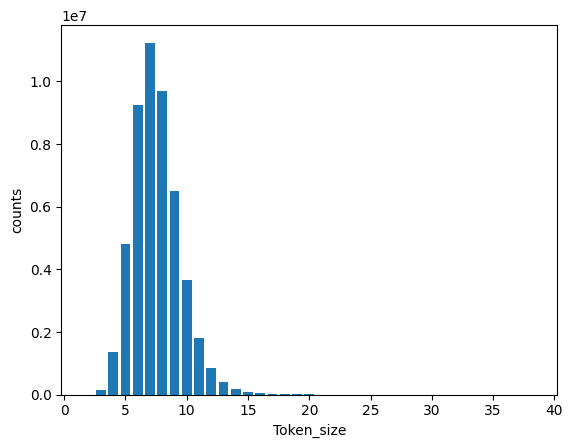

In [13]:
import matplotlib.pyplot as plt
length_list = {}


for index,i in enumerate(train_set):
    try:
        length_list[len(i)]=length_list[len(i)]+1
    except:
        length_list[len(i)] = 1
    
plt.bar(length_list.keys(),length_list.values())
plt.xlabel(xlabel='Token_size')
plt.ylabel('counts')    

In [14]:
temp_dict = {}
for i in train_set:
    for j in i:
        try:
            temp_dict[j] = temp_dict[j] + 1
        except:
            temp_dict[j] = 1
remove_dict = {}
for i in temp_dict.keys():
    if temp_dict[i]<50:
        print(i,temp_dict[i])
        remove_dict[i] = 1

remove_list = []
for index,i in enumerate(train_set):
    for j in i:
        try:
            remove_dict[j]
            remove_list.append(index)
            break
        except:
            continue

remove_list.sort(reverse=True)

[P@H+] 48
[P@@H+] 48
9 12
%10 4
[CH] 16
p 16
[CH2] 24
[Si-] 4
[P@+] 33
[P@@+] 31
[NH] 8
[17O] 12
[p+] 4


In [15]:
for i in remove_list:
    train_set.pop(i)
print(len(train_set))

50099943


In [16]:
import pickle
with open('./Pretraning_data/Random_ZINC_50M_SmilesPE_tokken.pkl','wb') as file:
    pickle.dump(train_set,file)

In [8]:
import pickle
with open('./Pretraning_data/Random_ZINC_50M_SmilesPE_tokken.pkl','rb') as file:
    train_set = pickle.load(file)

In [9]:
import pickle
molecule_dictionary = {'<start>':1,'<end>':2,'<unknown1>':3,'<unknown2>':4,'<unknown3>':5,'<unknow4>':6,'<unknown5>':7}

for molecule in train_set:
    for atom in molecule:
        try:
            molecule_dictionary[atom]
        except:
            molecule_dictionary[atom] = len(molecule_dictionary)+1
with open('./BERT/SmiletoPE/1M_random_ZINC_word2index.pkl','wb') as file:
    pickle.dump(molecule_dictionary,file)
len(molecule_dictionary)

3030

In [10]:
from tqdm import tqdm
import numpy as np 

def word_to_index(train_set,dict):
    result = []
    for molecule in tqdm(train_set):
        temp_list = []
        temp_list.append(1)
        for atom in molecule:
            temp_list.append(dict[atom])
        while len(temp_list)!=200:
            temp_list.append(0)
        result.append(temp_list)
    return result
embedding_word = word_to_index(train_set,molecule_dictionary)   
embedding_word = np.array(embedding_word)

  0%|          | 0/50099508 [00:00<?, ?it/s]

100%|██████████| 50099508/50099508 [15:09<00:00, 55106.81it/s] 


In [11]:
from tdc.single_pred import Tox
from Module import RDK
import atomInSmiles

def word_to_index(train_set,dict):
    result = []
    for molecule in tqdm(train_set):
        temp_list = []
        temp_list.append(1)
        for atom in molecule:
            temp_list.append(dict[atom])
        while len(temp_list)!=200:
            temp_list.append(0)
        result.append(temp_list)
    return result
train_val,tox_info = Tox(name = 'AMES').get_data(format = 'DeepPurpose')
train_set_val = []

train_val = Chem_generator(train_val[:5000])

train_set_val = RDK.smile_tokenize(train_val)
val_remove_list = []
for index,i in enumerate(train_set_val):
    if len(i) < 3:
        val_remove_list.append(index)
        continue
    for j in i:
        try:
            molecule_dictionary[j]
        except:
            val_remove_list.append(index)
            break
val_remove_list.sort(reverse=True)

for i in val_remove_list:
    train_set_val.pop(i)

embedding_word_val = word_to_index(train_set_val,molecule_dictionary)   
embedding_word_val = np.array(embedding_word_val)

Found local copy...
Loading...
Done!
100%|██████████| 18846/18846 [00:00<00:00, 70101.34it/s]


In [12]:
embedding_word_val

array([[   1,  315,  316, ...,    0,    0,    0],
       [   1,  923,  202, ...,    0,    0,    0],
       [   1,  315,  353, ...,    0,    0,    0],
       ...,
       [   1,  990,   13, ...,    0,    0,    0],
       [   1,   59, 1033, ...,    0,    0,    0],
       [   1, 1325, 1721, ...,    0,    0,    0]])

In [13]:
import random
max = 16
mask_input_val = []
for j in tqdm(train_set_val):
        value = []
        number = int(len(j)*0.15)
        if number>max:
                max = number
        if number == 0:
                number = 1
        value += random.sample(range(1,len(j)),number)
        mask_input_val.append(value)
        
        
for j in mask_input_val:
        while(len(j)<max):
                j.append(-1)


random_value_val = embedding_word_val.copy()        
for _,index in enumerate(mask_input_val):
        for j in index:
                if j != -1:
                        prob = np.random.rand(1)[0]
                        if prob < 0.8:
                                random_value_val[_][j] = 0
                        elif prob > 0.9:
                                temp1 = random.sample(range(0,301),1)[0]
                                random_value_val[_][j] = temp1
                                
output_val = tf.multiply(tf.reduce_sum(tf.one_hot(mask_input_val,200),axis=1),embedding_word_val)

100%|██████████| 18846/18846 [00:00<00:00, 241074.30it/s]


In [14]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import *
early_stopping_cb = EarlyStopping(patience=6, monitor='loss',restore_best_weights=True)

In [15]:
def custom_loss(y_true, y_pred):
    output = tf.one_hot(tf.cast(tf.boolean_mask(y_true,tf.cast(y_true,bool)),tf.int32),len(molecule_dictionary))
    loss = tf.keras.losses.CategoricalCrossentropy()(output,y_pred)
    return loss

In [16]:
def Custom_metric(y_true,y_pred):
    predictions = tf.argmax(y_pred,axis=1)
    true = tf.boolean_mask(y_true,tf.cast(y_true,bool))
    return  tf.metrics.Accuracy()(predictions,true)
def Mask_acc(y_true, y_pred):
    score = tf.py_function(func=Custom_metric, inp=[y_true, y_pred], Tout=tf.float32,  name='Custom_acc') 
    return score

In [39]:
class BERT(tf.keras.layers.Layer):
    def __init__(self,emb_dim,num_heads,ff_dim):
        super(BERT, self).__init__()
        self.transformer = TransformerBlock(emb_dim,num_heads,ff_dim)
        
        self.embedding = TokenAndPositionEmbedding(200,3500,256)
        self.dense = layers.Dense(250,activation = 'gelu')
        self.classify = layers.Dense(len(molecule_dictionary),activation = 'softmax')
    def call(self, inputs, mask_index,pretrain = False):
        if pretrain:
            mask_index = tf.one_hot(mask_index,200)
            boolean_mask = tf.cast(tf.reduce_sum(mask_index,axis=1),bool)
            inputs = tf.cast(inputs,dtype=tf.int32)
        
        hidden = self.embedding(inputs)
        for i in range(8):
            hidden = self.transformer(hidden)
    
        if pretrain:
            output = tf.reshape(hidden,[-1,200,256])
            output = tf.boolean_mask(output,boolean_mask)
            output = self.dense(output)
            output = layers.Dropout(0.1)(output)
            output = self.classify(output)
            return output
        else:
            return hidden

In [40]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,mask_zero=True)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim,mask_zero = True)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=1, limit=maxlen+1, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [41]:
import tensorflow as tf
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers import Embedding
inputs = Input(shape = (200,),dtype=tf.int32)
mask = Input(shape = (16), dtype=tf.int32)
outputs = BERT(256,6,1024)(inputs,mask,pretrain=True)

model = Model(inputs = [inputs,mask], outputs = [outputs])
model.summary()
optmizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optmizer,loss = custom_loss,metrics = Mask_acc)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 bert_3 (BERT)                  (None, 3030)         3876300     ['input_7[0][0]',                
                                                                  'input_8[0][0]']                
                                                                                                  
Total params: 3,876,300
Trainable params: 3,876,300
Non-trainable params: 0
________________

In [42]:
optmizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optmizer,loss = custom_loss,metrics = Mask_acc)

In [43]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=2000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.batch_count
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    self.batch_count += 1
    step = float(step+1)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(1000.) * tf.math.minimum(arg1, arg2)

In [44]:
class CustomLearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, warmup_steps=4000):
        super(CustomLearningRateScheduler, self).__init__()
        self.warmup_steps = warmup_steps
        self.step = tf.Variable(0, trainable=False)

    def __call__(self, step):
        self.step.assign_add(1)  # 각 배치가 지나갈 때마다 step 증가
        lr = tf.cond(
            self.step <= self.warmup_steps,
            lambda: (1e-4 - 1e-9) / self.warmup_steps * tf.cast(self.step, tf.float32) + 1e-9,
            lambda: 0.5 * (1e-4 + 1e-9) * (self.warmup_steps ** 0.5) / (tf.cast(self.step, tf.float32) ** 0.5)
        )
        return lr

In [45]:
lr = CustomLearningRateScheduler()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer= optimizer, loss = custom_loss, metrics= Mask_acc)

In [46]:
model.load_weights('./BERT/SmiletoPE/Random_ZINC_L_model_weights.h5')

In [48]:

import random
size = 300000
for k in range(1):
        for i in range(0,int(len(embedding_word)/size)):
                if k == 0:
                        i = i + 50
                if i == int(len(embedding_word)/size):
                        break
                if i <80:
                        lr = (1e-4-1e-6)*(i)/80 + 1e-6
                else:
                        lr = 1e-4*np.sqrt(80)/np.sqrt(i)
                optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
                model.compile(optimizer= optimizer, loss = custom_loss, metrics= Mask_acc)
                max = 16
                mask_input = []
                for j in tqdm(train_set[size*i:size*(i+1)]):
                        value = []
                        number = int(len(j)*0.15)
                        if number>max:
                                number = max
                        if number == 0:
                                number = 1
                        value += random.sample(range(1,len(j)),number)
                        mask_input.append(value)
                        
                        
                for j in mask_input:
                        while(len(j)<max):
                                j.append(-1)
                
                
                
                
                
                
                inputs1 = embedding_word[size*i:size*(i+1)]
                inputs2 = mask_input
                output = tf.multiply(tf.reduce_sum(tf.one_hot(inputs2,200),axis=1),inputs1)

                
                random_value = inputs1.copy()        
                for _,index in enumerate(inputs2):
                        for j in index:
                                if j != -1:
                                        prob = np.random.rand(1)[0]
                                        if prob < 0.8:
                                                random_value[_][j] = 0
                                        elif prob > 0.9:
                                                temp1 = random.sample(range(0,301),1)[0]
                                                random_value[_][j] = temp1
                                                
                
                
                print(f'This is {i} number step')
                with tf.device('/device:GPU:0'):
                        if i % 20 == 0:
                                model.fit([np.array(random_value),np.array(inputs2)],np.array(output,dtype = int),epochs=1,batch_size=256,callbacks = [early_stopping_cb],validation_data=([np.array(random_value_val),np.array(mask_input_val)],np.array(output_val)))
                        else:
                                model.fit([np.array(random_value),np.array(inputs2)],np.array(output,dtype = int),epochs=1,batch_size=256,callbacks = [early_stopping_cb])
                        print(model.optimizer.lr)
                        model.save_weights('./BERT/SmiletoPE/Random_ZINC_L_model_weights.h5')

  9%|▉         | 27748/300000 [00:00<00:00, 277461.08it/s]

100%|██████████| 300000/300000 [00:00<00:00, 358497.22it/s]


This is 50 number step
1172/1172 [==============================] - 366s 306ms/step - loss: 5.6862 - Mask_acc: 0.1199
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=6.2875e-05>


100%|██████████| 300000/300000 [00:00<00:00, 358751.53it/s]


This is 51 number step
1172/1172 [==============================] - 367s 307ms/step - loss: 5.7314 - Mask_acc: 0.1203
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=6.41125e-05>


100%|██████████| 300000/300000 [00:00<00:00, 357069.52it/s]


This is 52 number step
1172/1172 [==============================] - 367s 307ms/step - loss: 5.6373 - Mask_acc: 0.1206
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=6.535e-05>


100%|██████████| 300000/300000 [00:00<00:00, 360532.59it/s]


This is 53 number step
1172/1172 [==============================] - 367s 307ms/step - loss: 5.6283 - Mask_acc: 0.1181
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=6.65875e-05>


100%|██████████| 300000/300000 [00:00<00:00, 353718.77it/s]


This is 54 number step
1172/1172 [==============================] - 367s 308ms/step - loss: 5.6377 - Mask_acc: 0.1190
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=6.7825e-05>


100%|██████████| 300000/300000 [00:00<00:00, 357588.56it/s]


This is 55 number step
1172/1172 [==============================] - 367s 307ms/step - loss: 5.7251 - Mask_acc: 0.1218
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=6.90625e-05>


100%|██████████| 300000/300000 [00:00<00:00, 358031.26it/s]


This is 56 number step
1172/1172 [==============================] - 367s 308ms/step - loss: 5.6382 - Mask_acc: 0.1211
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=7.03e-05>


100%|██████████| 300000/300000 [00:00<00:00, 349715.35it/s]


This is 57 number step
1172/1172 [==============================] - 367s 308ms/step - loss: 5.6833 - Mask_acc: 0.1236
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=7.15375e-05>


100%|██████████| 300000/300000 [00:00<00:00, 353047.37it/s]


This is 58 number step
1172/1172 [==============================] - 365s 306ms/step - loss: 5.6257 - Mask_acc: 0.1225
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=7.2775e-05>


100%|██████████| 300000/300000 [00:00<00:00, 352017.03it/s]


This is 59 number step
1172/1172 [==============================] - 366s 307ms/step - loss: 5.6713 - Mask_acc: 0.1266
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=7.40125e-05>


100%|██████████| 300000/300000 [00:00<00:00, 346582.56it/s]


This is 60 number step
1172/1172 [==============================] - 376s 315ms/step - loss: 5.5470 - Mask_acc: 0.1229 - val_loss: 6.2879 - val_Mask_acc: 0.1089
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=7.525e-05>


100%|██████████| 300000/300000 [00:00<00:00, 351267.72it/s]


This is 61 number step
1172/1172 [==============================] - 367s 308ms/step - loss: 5.5774 - Mask_acc: 0.1203
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=7.64875e-05>


100%|██████████| 300000/300000 [00:00<00:00, 335732.15it/s]


This is 62 number step
1172/1172 [==============================] - 367s 308ms/step - loss: 5.6063 - Mask_acc: 0.1261
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=7.7725e-05>


100%|██████████| 300000/300000 [00:00<00:00, 355352.92it/s]


This is 63 number step
1172/1172 [==============================] - 411s 308ms/step - loss: 5.6631 - Mask_acc: 0.1233
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=7.89625e-05>


100%|██████████| 300000/300000 [00:00<00:00, 323185.70it/s]


This is 64 number step
 379/1172 [========>.....................] - ETA: 4:03 - loss: 5.6249 - Mask_acc: 0.1247

In [ ]:
temp_weights = model.get_weights()
all_weights = temp_weights[:16]*8 + temp_weights[16:]

In [ ]:
class BERT(tf.keras.layers.Layer):
    def __init__(self,emb_dim,num_heads,ff_dim):
        super(BERT, self).__init__()
        self.encoder = tf.keras.Sequential([TransformerBlock(emb_dim,num_heads,ff_dim) for i in range(8)])
        #self.encoder = TransformerBlock(emb_dim,num_heads,ff_dim)
        #self.normalize = tf.keras.layers.LayerNormalization(epsilon=1e-8)
        
        self.embedding = TokenAndPositionEmbedding(200,3500,256)
        self.dense = layers.Dense(250,activation = 'gelu')
        self.classify = layers.Dense(len(molecule_dictionary),activation = 'softmax')
    def call(self, inputs, mask_index,pretrain = False):
        if pretrain:
            mask_index = tf.one_hot(mask_index,200)
            boolean_mask = tf.cast(tf.reduce_sum(mask_index,axis=1),bool)
            inputs = tf.cast(inputs,dtype=tf.int32)
            
        hidden = self.embedding(inputs)
        hidden = self.encoder(hidden)
    
        if pretrain:
            output = tf.reshape(hidden,[-1,200,256])
            output = self.dense(output)
            output = layers.Dropout(0.1)(output)
            output = self.classify(output)
            output = tf.boolean_mask(output,boolean_mask)
            return output
        else:
            return hidden

In [ ]:
inputs = Input(shape = (200,),dtype=tf.int32)
mask = Input(shape = (16), dtype=tf.int32)
outputs = BERT(256,6,1024)(inputs,mask,pretrain=True)

model = Model(inputs = [inputs,mask], outputs = [outputs])
model.summary()
optmizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optmizer,loss = custom_loss,metrics = Mask_acc)
model.set_weights(all_weights)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 bert_1 (BERT)                  (None, 3030)         18606540    ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
Total params: 18,606,540
Trainable params: 18,606,540
Non-trainable params: 0
______________

In [ ]:
random_value_val

array([], dtype=float64)

In [ ]:
import random
size = 300000
for k in range(11):
        for i in range(0,int(len(embedding_word)/size)):
                if k == 1:
                        i = i
                if i == int(len(embedding_word)/size):
                        break
                if i <80:
                        lr = (1e-4-1e-6)*(i)/80 + 1e-6
                else:
                        lr = 1e-4*np.sqrt(80)/np.sqrt(i)
                optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
                model.compile(optimizer= optimizer, loss = custom_loss, metrics= Mask_acc)
                max = 16
                mask_input = []
                for j in tqdm(train_set[size*i:size*(i+1)]):
                        value = []
                        number = int(len(j)*0.15)
                        if number>max:
                                number = max
                        if number == 0:
                                number = 1
                        value += random.sample(range(1,len(j)),number)
                        mask_input.append(value)
                        
                        
                for j in mask_input:
                        while(len(j)<max):
                                j.append(-1)
                
                
                
                
                
                
                inputs1 = embedding_word[size*i:size*(i+1)]
                inputs2 = mask_input
                output = tf.multiply(tf.reduce_sum(tf.one_hot(inputs2,200),axis=1),inputs1)

                
                random_value = inputs1.copy()        
                for _,index in enumerate(inputs2):
                        for j in index:
                                if j != -1:
                                        prob = np.random.rand(1)[0]
                                        if prob < 0.8:
                                                random_value[_][j] = 0
                                        elif prob > 0.9:
                                                temp1 = random.sample(range(0,301),1)[0]
                                                random_value[_][j] = temp1
                                                
                
                
                print(f'This is {i} number step')
                with tf.device('/device:GPU:0'):
                        if i % 20 == 0:
                                model.fit([np.array(random_value),np.array(inputs2)],np.array(output,dtype = int),epochs=1,batch_size=256,callbacks = [early_stopping_cb],validation_data=([np.array(random_value_val),np.array(mask_input_val)],np.array(output_val)))
                        else:
                                model.fit([np.array(random_value),np.array(inputs2)],np.array(output,dtype = int),epochs=1,batch_size=256,callbacks = [early_stopping_cb])
                        print(model.optimizer.lr)
                        model.save_weights('./BERT/SMILE/Random_ZINC_L_model_weights.h5')

 22%|██▏       | 65271/300000 [00:00<00:00, 332004.45it/s]

100%|██████████| 300000/300000 [00:00<00:00, 354049.89it/s]


This is 0 number step
 270/1172 [=====>........................] - ETA: 4:52 - loss: 5.7561 - Mask_acc: 0.1201

KeyboardInterrupt: 

In [ ]:
res_weights = model.get_weights()
res_weights = res_weights[:130]

In [ ]:
inputs = Input(shape = (200,),dtype=tf.int32)
outputs = BERT(256,6,1024)(inputs,None)

res_model = Model(inputs = [inputs,mask], outputs = [outputs])
res_model.summary()

In [ ]:
res_model.save_weights('./BERT/SmiletoPE/Pre_BERT.h5')